# Modelling Cottesloe Peak Period
### Author: Johnny Barrett

In [102]:
import pandas as pd
import numpy as np
import plotly.express as px
from plot_template import theme, conf_matrix_vis
pd.options.plotting.backend = 'plotly'
px.defaults.template = 'plotly_dark'
px.defaults.height = 650
px.defaults.width = 1000

plasma = px.colors.sequential.Plasma
plasma_cyc = plasma[1:-1] + plasma[::-1][2:-1]

In [31]:
def show(plot, h=6.5, w=10, thm=True):
    if thm:
        plot = theme(plot)
    plot.show(height=h*100, width=w*100, renderer='png')

In [49]:
df = pd.read_csv('../ocean-waves-full.csv', parse_dates=['DateTime'])

# EDA

In [50]:
SEASONS = ['Summer','Autumn','Winter','Spring']

def month_to_season(month, name=False):
    season_num = (month%12 + 3) // 3
    if name:
        return SEASONS[season_num - 1]
    else:
        return season_num

In [51]:
df['Season'] = df['Month'].apply(month_to_season, name=True).astype('category')
df['Season'].cat.set_categories(
    SEASONS, ordered=True, inplace=True
)
df['SeasonNum'] = df['Month'].apply(month_to_season)
df['Year'] = df['DateTime'].dt.year

In [52]:
df['YearSeason'] = df.apply(lambda row: f"{row['Year']}.{row['SeasonNum']}", axis=1)

In [53]:
period_cols = [col for col in df if 'Period' in col]
df[period_cols] = df[period_cols].apply(round, ndigits=4)

In [54]:
log_p = df[period_cols].apply(np.log)\
            .rename(columns={col: f"log{''.join([c for c in col if c.isupper()])}" for col in df})
df = pd.concat([df, log_p], axis=1)

In [55]:
unique = df[period_cols].apply(lambda x: x.unique())
cp = unique['CottPeakPeriod']
rp = unique['RottPeakPeriod']
cm = unique['CottMeanPeriod']
rm = unique['RottMeanPeriod']

In [56]:
cp_log = np.log(cp)
rp_log = np.log(rp)

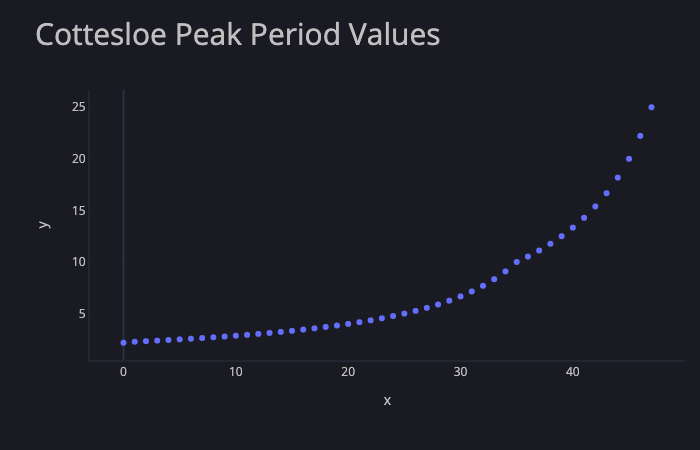

In [57]:
p1 = px.scatter(x=list(range(len(cp))), y=sorted(cp), title='Cottesloe Peak Period Values')
show(p1, h=4.5, w=7)

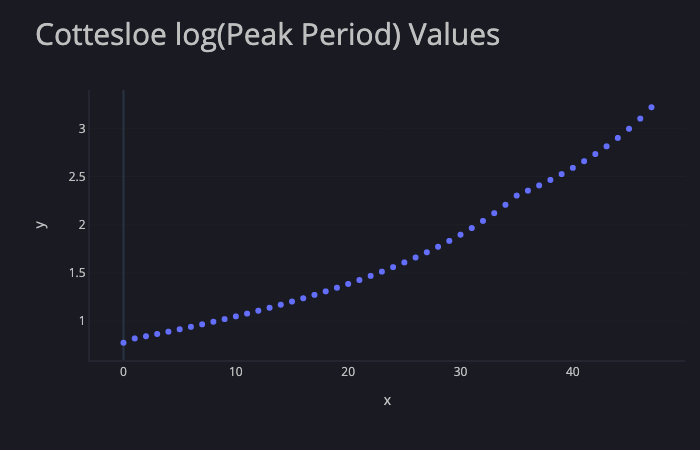

In [58]:
p2 = px.scatter(x=list(range(len(cp))), y=sorted(cp_log), title='Cottesloe log(Peak Period) Values')
show(p2, h=4.5, w=7)

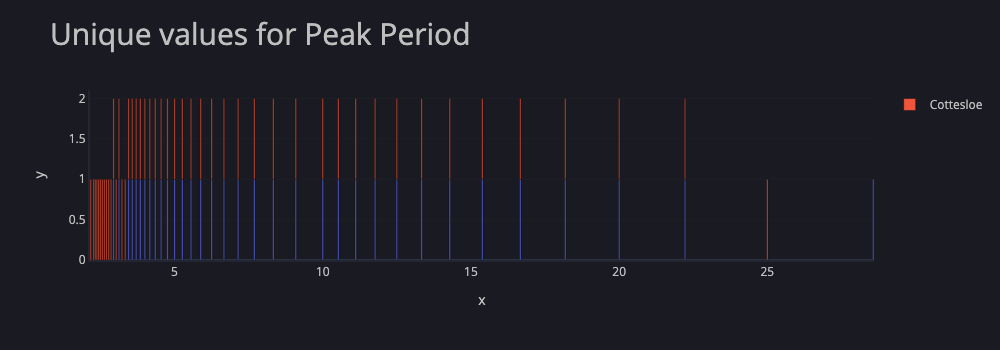

In [59]:
p3 = px.bar(x=rp, y=[1 for i in range(len(rp))], title='Unique values for Peak Period')\
     .add_bar(x=cp, y=[1 for i in range(len(cp))], name='Cottesloe')
show(p3, h=3.5)

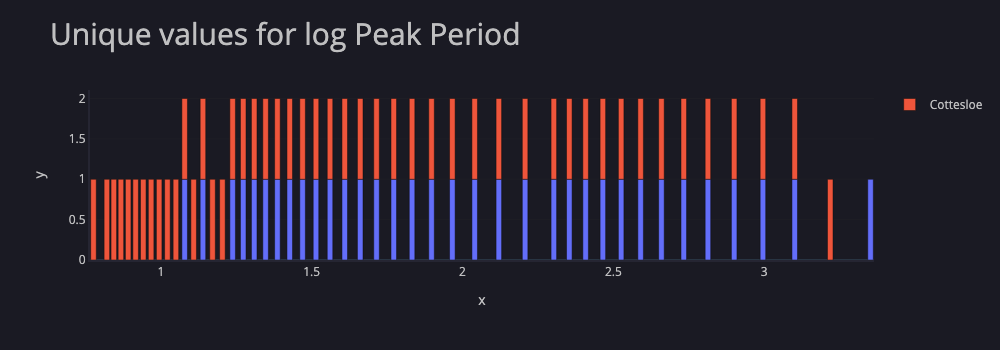

In [60]:
p4 = px.bar(x=rp_log, y=[1 for i in range(len(rp_log))], title='Unique values for log Peak Period')\
     .add_bar(x=cp_log, y=[1 for i in range(len(cp_log))], name='Cottesloe')
show(p4, h=3.5)

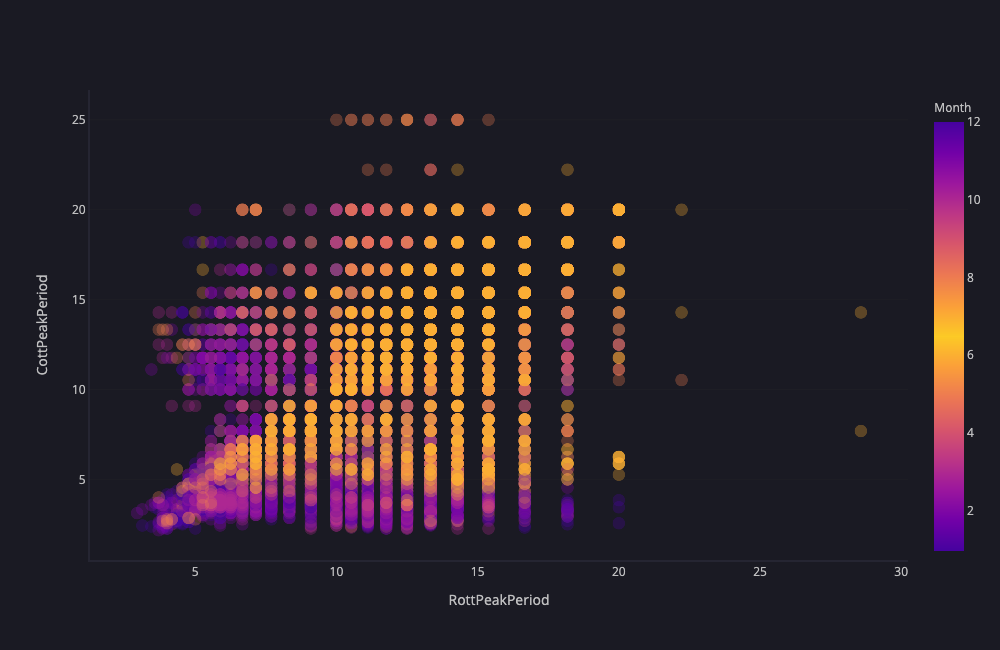

In [61]:
p5 = df.plot.scatter('RottPeakPeriod', 'CottPeakPeriod', color='Month',
    color_continuous_scale=plasma_cyc, template='plotly_dark', opacity=0.3)\
        .update_traces(marker=dict(size=10))
show(p5)

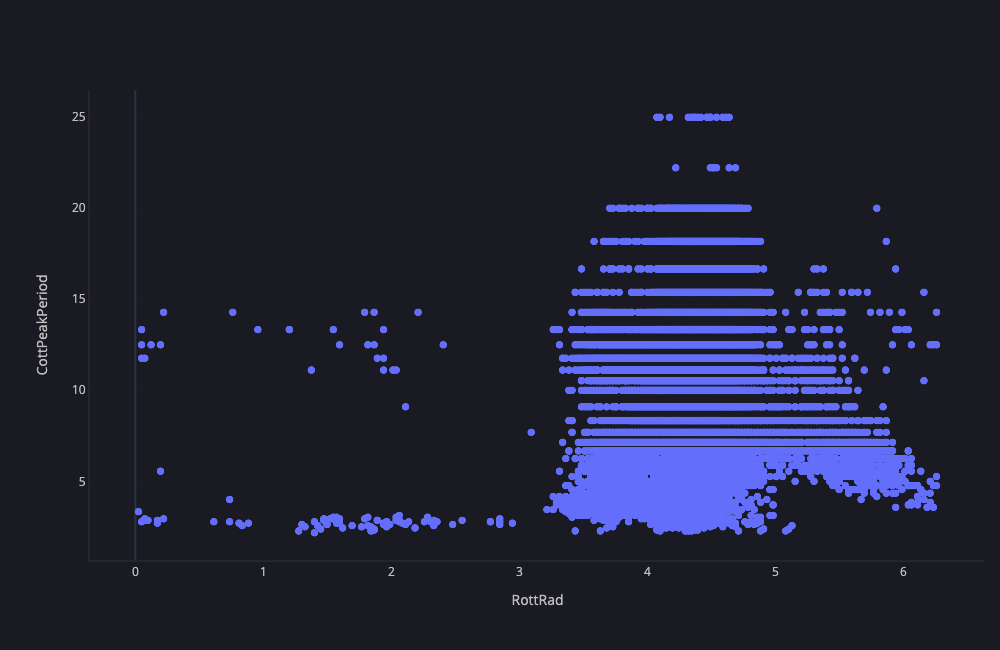

In [63]:
show(px.scatter(df, 'RottRad', 'CottPeakPeriod'))

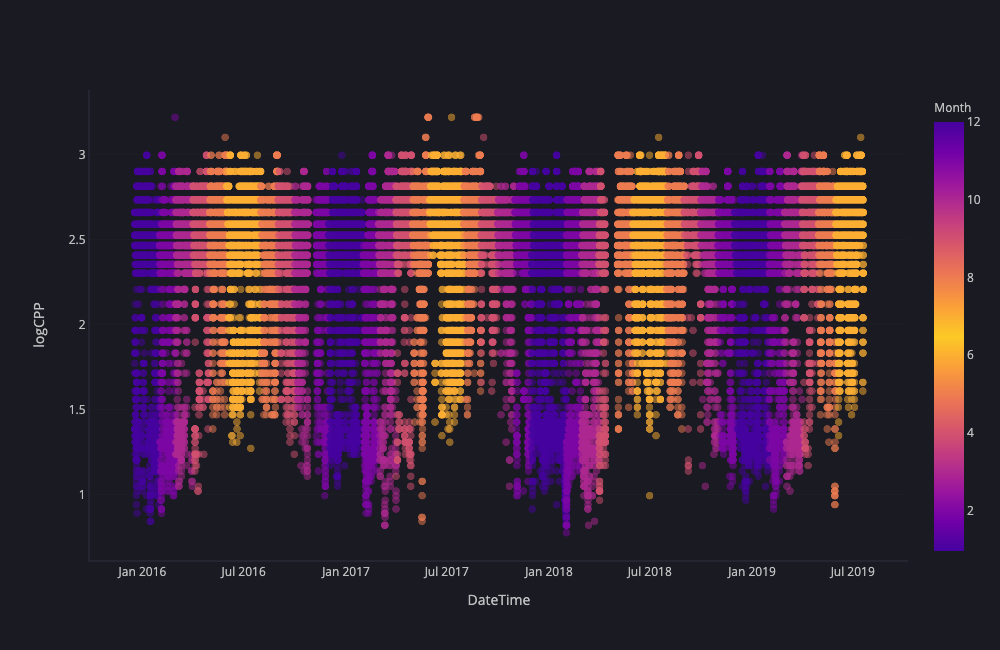

In [64]:
show(px.scatter(df, 'DateTime', 'logCPP', color='Month', color_continuous_scale=plasma_cyc, opacity=0.5))

In [65]:
g = df.groupby(['Year','Season'], as_index=False)['CottPeakPeriod'].mean()

In [66]:
def cont_seasons(x):
    map_ = {'1': '.0', '2': '.25', '3': '.5', '4': '.75'}
    yr = x.split('.')[0]
    ssn_num = x.split('.')[-1]
    return f'{yr}{map_[ssn_num]}'

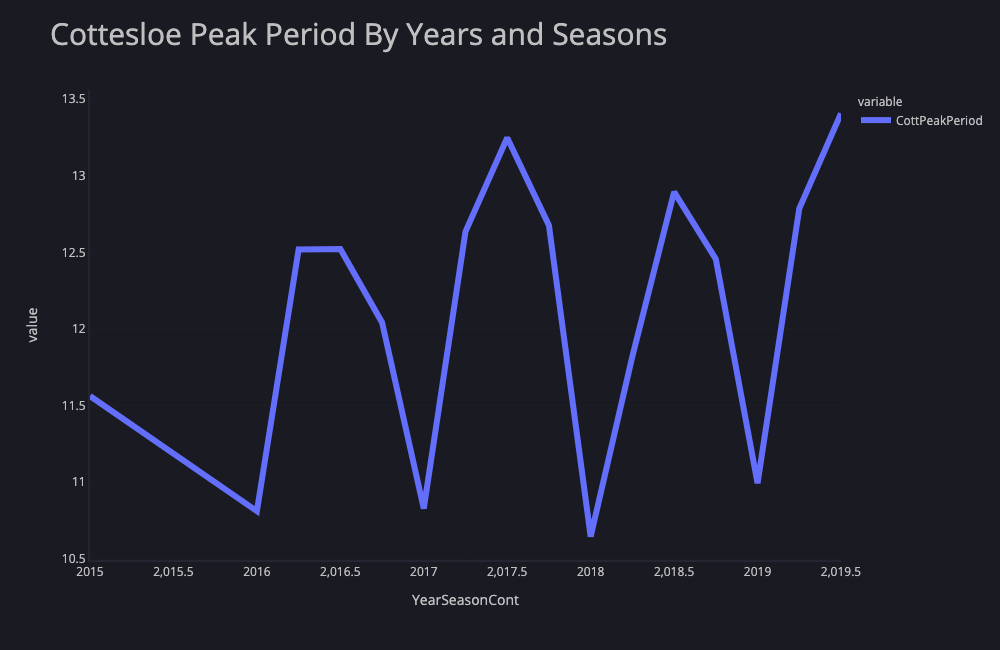

In [67]:
df = df.assign(YearSeasonCont=df['YearSeason'].apply(cont_seasons))
show(df.groupby('YearSeasonCont')['CottPeakPeriod'].mean().plot.line(
    title='Cottesloe Peak Period By Years and Seasons').update_traces(line_width=6))

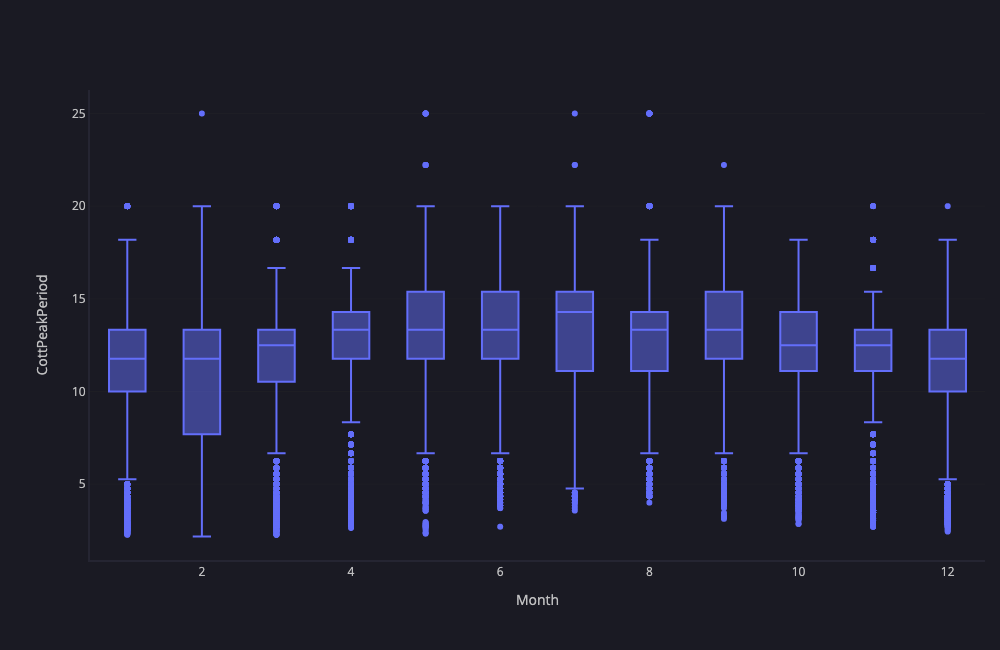

In [71]:
show(df.plot.box(x='Month', y='CottPeakPeriod'))

___
# Modelling
## 1  Regression

In [129]:
from sklearn.model_selection import train_test_split

In [349]:
# dropping 1 value, necessary for stratification:
df_ = df.query('logCPP > 0.8')

X = df_[['RottHeight','logRPP','RottRad']]
X = pd.concat([X, pd.get_dummies(df_['Season'])], axis=1)
y = df_['logCPP']

In [350]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

### Checking stratification 

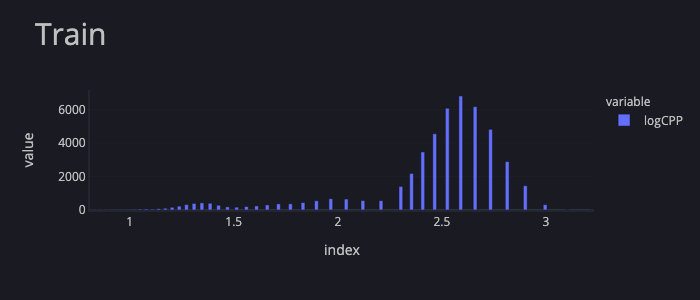

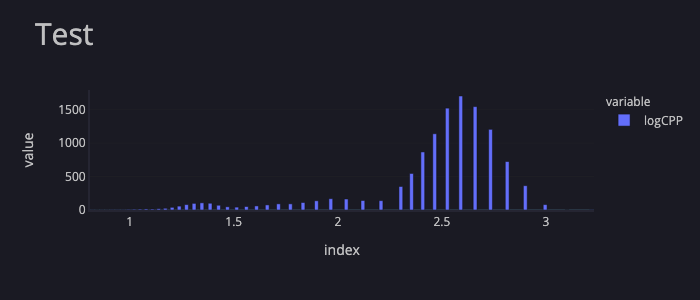

In [351]:
show(y_train.value_counts().plot.bar(title='Train'), h=3, w=7)
show(y_test.value_counts().plot.bar(title='Test'), h=3, w=7)

In [285]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error

def mape(y_true, y_pred):
    return np.mean(abs(y_true-y_pred) / y_true)

### Random Forest Regressor

In [286]:
rfr = RandomForestRegressor(n_estimators=300, random_state=0, max_depth=15, max_features=0.5, verbose=1)

In [287]:
rfr.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   23.4s finished


RandomForestRegressor(max_depth=15, max_features=0.5, n_estimators=300,
                      random_state=0, verbose=1)

In [288]:
y_pred_train = rfr.predict(X_train)
y_pred_test = rfr.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.1s finished


In [289]:
y_pred_train = rfr.predict(X_train)
y_pred_test = rfr.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.8s finished


In [290]:
y_train_lin, y_pred_train = np.exp(y_train), np.exp(y_pred_train)
y_test_lin, y_pred_test = np.exp(y_test), np.exp(y_pred_test)

In [291]:
print('Train')
print(f'mape: {mape(y_train_lin, y_pred_train)}')
print(f'mse: {mean_squared_error(y_train_lin, y_pred_train)}')
print()
print('Test')
print(f'mape: {mape(y_test_lin, y_pred_test)}')
print(f'mse: {mean_squared_error(y_test_lin, y_pred_test)}')

Train
mape: 0.17719072977924963
mse: 4.75870618393255

Test
mape: 0.23442852148274468
mse: 7.810780115545645


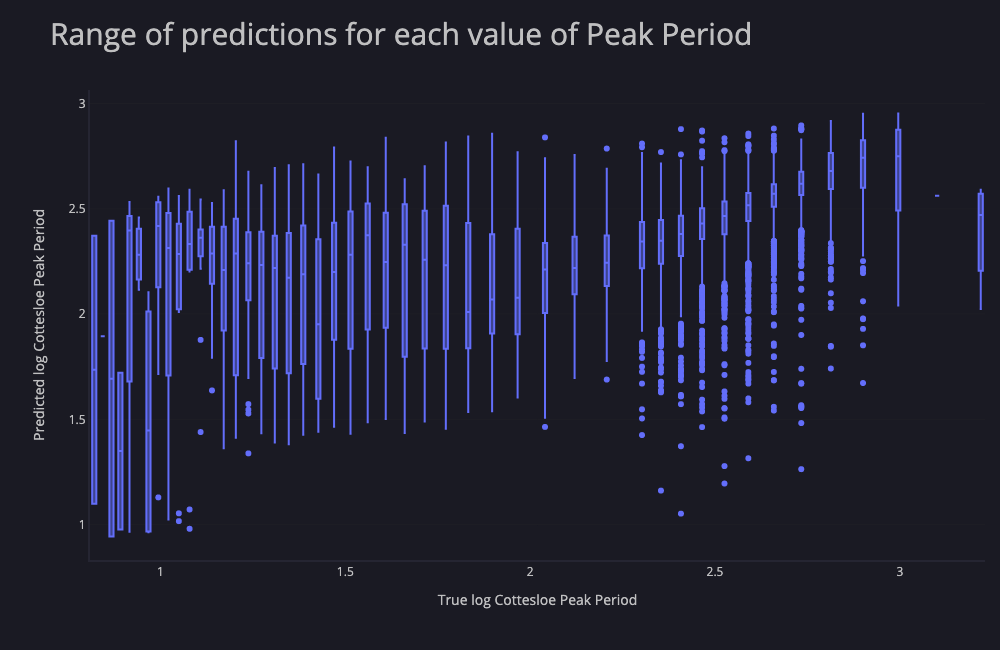

In [215]:
show(px.box(x=y_test, y=np.log(y_pred_test), title='Range of predictions for each value of Peak Period')\
        .update_xaxes(title='True log Cottesloe Peak Period')\
        .update_yaxes(title='Predicted log Cottesloe Peak Period'))

### AdaBoost Regressor

In [292]:
ada = AdaBoostRegressor(random_state=0, n_estimators=200, learning_rate=0.01)

In [293]:
ada.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.01, n_estimators=200, random_state=0)

In [294]:
y_pred_train = ada.predict(X_train)
y_pred_test = ada.predict(X_test)
y_pred_train = ada.predict(X_train)
y_pred_test = ada.predict(X_test)

y_train_lin, y_pred_train = np.exp(y_train), np.exp(y_pred_train)
y_test_lin, y_pred_test = np.exp(y_test), np.exp(y_pred_test)

print('Train')
print(f'mape: {mape(y_train_lin, y_pred_train)}')
print(f'mse: {mean_squared_error(y_train_lin, y_pred_train)}')
print()
print('Test')
print(f'mape: {mape(y_test_lin, y_pred_test)}')
print(f'mse: {mean_squared_error(y_test_lin, y_pred_test)}')

Train
mape: 0.2606073501766369
mse: 9.090838027495398

Test
mape: 0.2599396399492071
mse: 9.102267805926768


### Gradient Boosting Regressor

In [352]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(loss='huber', n_estimators=500, learning_rate=0.05, verbose=True)
gbr.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.0685           25.45s
         2           0.0660           38.48s
         3           0.0638           42.23s
         4           0.0611           39.02s
         5           0.0590           40.45s
         6           0.0571           39.76s
         7           0.0550           38.01s
         8           0.0539           36.40s
         9           0.0523           35.47s
        10           0.0511           34.89s
        20           0.0444           34.62s
        30           0.0414           36.06s
        40           0.0396           38.23s
        50           0.0381           41.06s
        60           0.0375           40.53s
        70           0.0370           37.78s
        80           0.0367           35.94s
        90           0.0365           33.58s
       100           0.0365           31.54s
       200           0.0360           20.87s
       300           0.0357           13.11s
       40

GradientBoostingRegressor(learning_rate=0.05, loss='huber', n_estimators=500,
                          verbose=True)

In [348]:
y_pred_train = gbr.predict(X_train)
y_pred_test =  gbr.predict(X_test)
y_pred_train = gbr.predict(X_train)
y_pred_test =  gbr.predict(X_test)

y_train_lin, y_pred_train = np.exp(y_train), np.exp(y_pred_train)
y_test_lin, y_pred_test = np.exp(y_test), np.exp(y_pred_test)

print('Train')
print(f'mape: {mape(y_train_lin, y_pred_train)}')
print(f'mse: {mean_squared_error(y_train_lin, y_pred_train)}')
print()
print('Test')
print(f'mape: {mape(y_test_lin, y_pred_test)}')
print(f'mse: {mean_squared_error(y_test_lin, y_pred_test)}')

Train
mape: 0.07419205456861883
mse: 2.086105107228578

Test
mape: 0.07596504703861283
mse: 2.1578477136903698


### Best regressor on all data
Gradient boosting regressor: 22.64% MAPE, 7.32 seconds MSE

## 2  Regression on central range of Cottesloe Peak Period

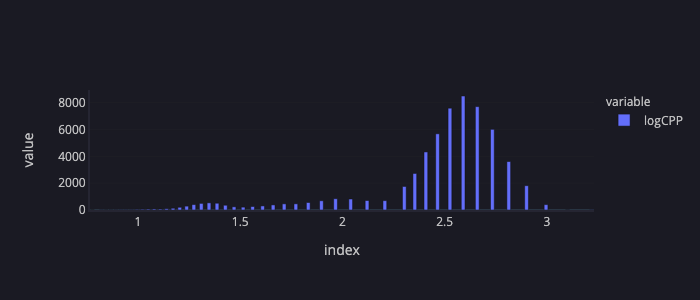

In [370]:
show(df['logCPP'].value_counts().plot.bar(), h=3, w=7)

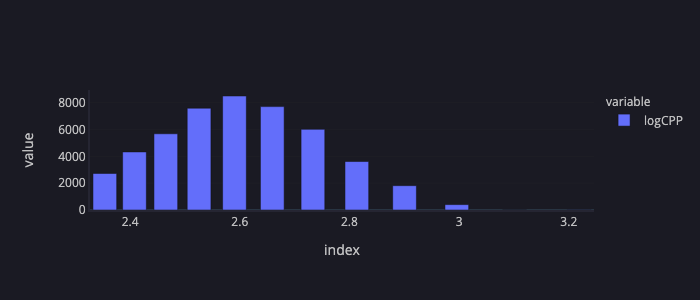

In [413]:
df_ = df.query('10 < CottPeakPeriod')
show(df_['logCPP'].value_counts().plot.bar(), h=3, w=7)

In [372]:
perc = round(len(df_) / len(df) * 100, 2)
print(f"{perc}% of values for Cottesloe Peak Period are above 10 seconds")

80.38% of values for Cottesloe Peak Period are above 10 seconds


In [414]:
X = df_[['RottHeight','logRPP','RottRad']]
X = pd.concat([X, pd.get_dummies(df_['Season'])], axis=1)
y = df_['logCPP']

In [415]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [378]:
gbr.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.0097           21.79s
         2           0.0092           22.50s
         3           0.0089           23.99s
         4           0.0085           24.57s
         5           0.0082           24.29s
         6           0.0079           23.84s
         7           0.0076           23.15s
         8           0.0073           22.45s
         9           0.0071           21.85s
        10           0.0069           21.58s
        20           0.0056           20.96s
        30           0.0051           20.47s
        40           0.0050           19.61s
        50           0.0049           19.19s
        60           0.0049           23.39s
        70           0.0048           22.44s
        80           0.0048           21.34s
        90           0.0048           21.01s
       100           0.0048           20.39s
       200           0.0048           15.13s
       300           0.0047           10.14s
       40

GradientBoostingRegressor(learning_rate=0.05, loss='huber', n_estimators=500,
                          verbose=True)

In [379]:
y_pred_train = gbr.predict(X_train)
y_pred_test =  gbr.predict(X_test)
y_pred_train = gbr.predict(X_train)
y_pred_test =  gbr.predict(X_test)

y_train_lin, y_pred_train = np.exp(y_train), np.exp(y_pred_train)
y_test_lin, y_pred_test = np.exp(y_test), np.exp(y_pred_test)

print('Train')
print(f'mape: {mape(y_train_lin, y_pred_train)}')
print(f'mse: {mean_squared_error(y_train_lin, y_pred_train)}')
print()
print('Test')
print(f'mape: {mape(y_test_lin, y_pred_test)}')
print(f'mse: {mean_squared_error(y_test_lin, y_pred_test)}')

Train
mape: 0.07419205456861883
mse: 2.086105107228578

Test
mape: 0.0759617227853762
mse: 2.157523750928118


In [416]:
ftr_imprt = pd.DataFrame(dict(
        importance=gbr.feature_importances_),
                        index=X_train.columns)\
    .sort_values('importance', ascending=False)

season_imprt = ftr_imprt[ftr_imprt.index.isin(SEASONS)]['importance'].sum()
ftr_imprt.loc['Season'] = season_imprt
ftr_imprt = ftr_imprt.drop(SEASONS).apply(lambda x: round(x*100, 2))

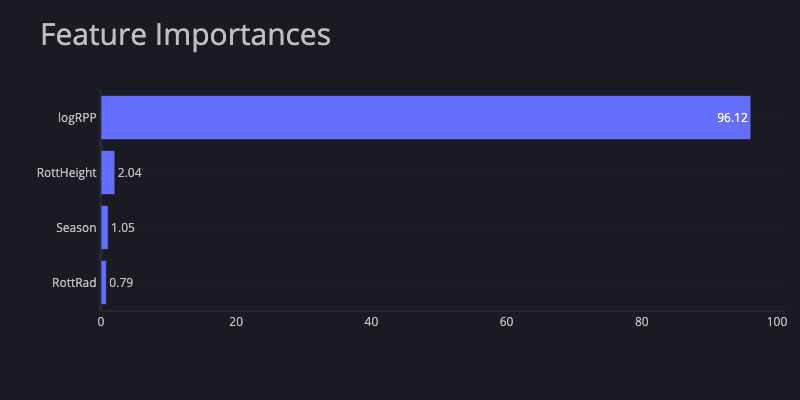

In [417]:
p15 = ftr_imprt.sort_values('importance').plot.bar(
    orientation='h',text='value', title='Feature Importances', labels={'index': '', 'value': ''}
        ).update_layout(showlegend=False)
show(p15, h=4, w=8)

### Conclusion
In the real world, the difference in affect/impact between a 4 and 8 second peak swell period is most often insignificant. High accuracy is acheivable on the more important part of the data (above 10 seconds). Rottnest Peak Period is by far the best predictor for Cottesloe Peak Period, with Season and Direction being insignificant enough to warrant removing to maximise model simplicity and interpretability.

___
## 3  Classification

In [398]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

In [401]:
def classification_eval(model, y_true, y_pred, title, figsize=(12,8)):
    acc = round(accuracy_score(y_true, y_pred), 3)
    f1 = round(f1_score(y_true, y_pred, average='macro'), 3)
    conf_matrix_vis(y_true, y_pred, title, acc, f1, figsize=figsize)
    return acc, f1

In [391]:
X = df_[['RottHeight','logRPP']]
X = pd.concat([X, pd.get_dummies(df_['Season'])], axis=1)
y = df_['CPPbinCodes']

In [392]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [393]:
gbc = GradientBoostingClassifier(n_estimators=200, random_state=0, verbose=True)

In [394]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=200, random_state=0)

In [395]:
y_pred_train = gbc.predict(X_train)
y_pred_test =  gbc.predict(X_test)
y_pred_train = gbc.predict(X_train)
y_pred_test =  gbc.predict(X_test)

In [405]:
from plot_template import conf_matrix_vis

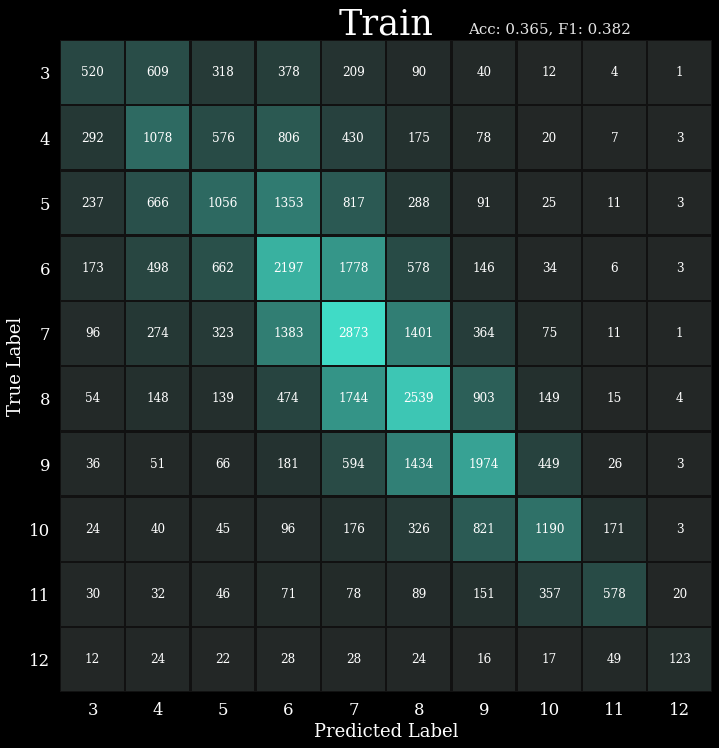

In [406]:
acc_train, f1_train = classification_eval(gbc, y_train, y_pred_train, 'Train', figsize=(12,12))

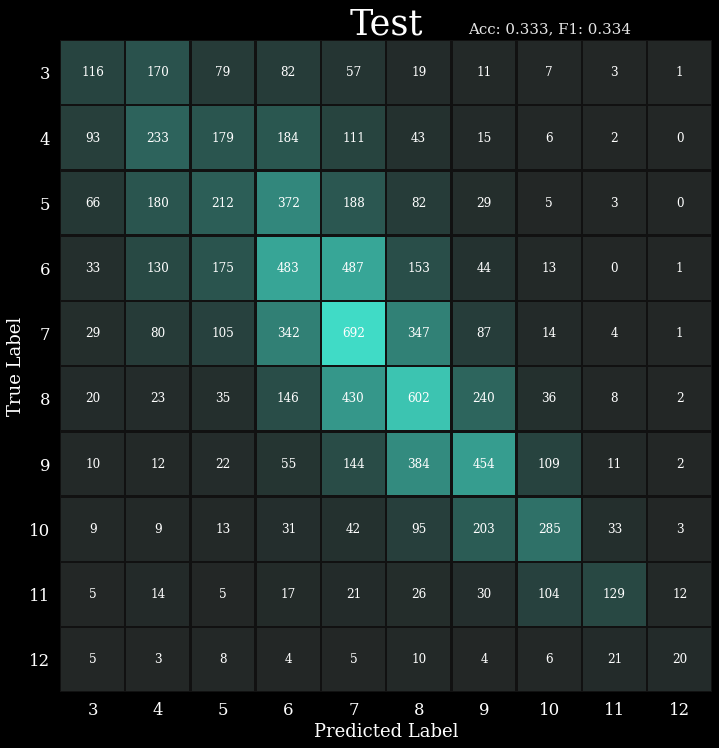

In [407]:
acc_test, f1_test = classification_eval(gbc, y_test, y_pred_test, 'Test', figsize=(12,12))

In [408]:
ftr_imprt = pd.DataFrame(dict(
        importance=gbc.feature_importances_),
                        index=X_train.columns)\
    .sort_values('importance', ascending=False)

season_imprt = ftr_imprt[ftr_imprt.index.isin(SEASONS)]['importance'].sum()
ftr_imprt.loc['Season'] = season_imprt
ftr_imprt = ftr_imprt.drop(SEASONS).apply(lambda x: round(x*100, 2))

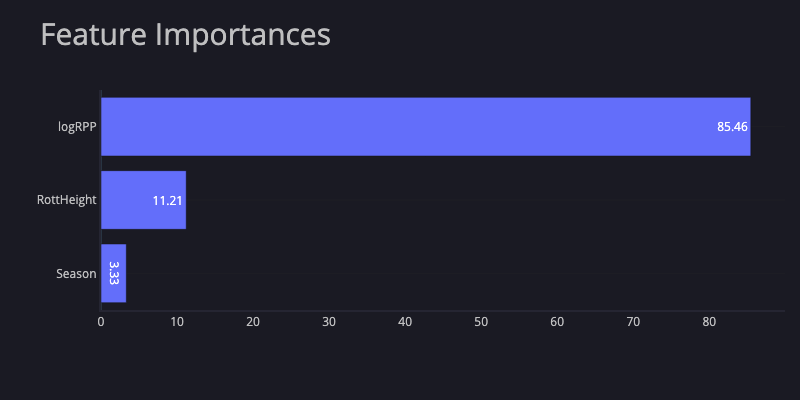

In [410]:
p16 = ftr_imprt.sort_values('importance').plot.bar(
    orientation='h',text='value', title='Feature Importances', labels={'index': '', 'value': ''}
        ).update_layout(showlegend=False)
show(p16, h=4, w=8)

### Conclusion
Predicting peak period can also be seen as a classification problem, and the confusion matrices above show that it can be effective. Evaluating a model such as this can not be done with standard metrics like accuracy and F1, as these metrics to not account for the ordinal nature of the data.

___